In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
arma_data = {'braidwood_covid':["./Output_Braidwood_2012_2021_DA/synthetic.csv", "../data/electricity_markets/PJM_braidwood/"],
              'braidwood_non_covid':["./Output_Braidwood_2012_2019_DA/synthetic.csv", "../data/electricity_markets/PJM_braidwood/"],
              'davis_besse':["./Output_davis_besse_2012_2021_DA/synthetic.csv", "../data/electricity_markets/PJM_davis_besse/"], 
              'ginna':["./Output_ginna_2012_2021_DA/synthetic.csv", "../data/electricity_markets/NYISO_ginna/"],
              'fitzpatrick':["./Output_fitzpatrick_2012_2021_DA/synthetic.csv", "../data/electricity_markets/NYISO_fitzpatrick/"],
              'nine_mile_point':["./Output_nine_mile_point_2012_2021_DA/synthetic.csv", "../data/electricity_markets/NYISO_nine_mile_point/"],
              'houston':["./Output_houston_2012_2021_DA/synthetic.csv", "../data/electricity_markets/ERCOT_houston/"], 
              'cooper': ["./Output_cooper_2014_2021_DA/synthetic.csv", "../data/electricity_markets/SPP_cooper/"],
              'prairie_island_1': ["./Output_prairie_island_1_2013_2021_DA/synthetic.csv", "../data/electricity_markets/MISO_prairie_island_1/"],
              'stp_1': ["Output_stp_1_2012_2021_DA/synthetic.csv", "../data/electricity_markets/ERCOT_stp_1/"]}


case = "stp_1"


if case not in arma_data.keys():
  raise KeyError("{}, Case not in dictionary".format(case))
filename = arma_data[case][0]
data_dir = arma_data[case][1]

synthetic_df = pd.read_csv(filename)
tag = filename.split('/')[1][7:]
synthetic_df.head()
#only keep first 4 years of data
synthetic_df = synthetic_df[synthetic_df['Year']<=2021]
# Remove useless data
synthetic_df.drop(columns=['scaling', 'RAVEN_sample_ID','prefix', 'PointProbability', 'ProbabilityWeight'], inplace=True)
synthetic_df.rename({'price':'synthetic price'}, axis=1, inplace=True)
print(tag)
synthetic_df

ic.csv


,hour,Year,synthetic price
0,1,2012,22.570153
1,1,2013,18.135782
2,1,2014,19.651613
3,1,2015,18.038203
4,1,2016,10.073798
...,...,...,...
332847,8760,2017,74.457104
332848,8760,2018,31.901746
332849,8760,2019,33.508848
332850,8760,2020,6.610129


In [3]:
# Get year list from synthetic data
years_list  = synthetic_df.Year.unique()
print(years_list)
files_names = os.listdir(data_dir)
li = []
for f in files_names: 
  if f.endswith('csv') and 'historical' not in f:
    year = int(f.split('_')[0])
    if year in years_list:
      file = data_dir+f
      df = pd.read_csv(file)
      df['Year'] = [year for i in range(len(df))]
      li.append(df)
hist_df = pd.concat(li, axis=0, ignore_index=True)
hist_df.rename({'price':'historical price'}, axis=1,inplace=True)
hist_df.to_csv(os.path.join(data_dir,"historical_prices.csv"),index=False)

[2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]


Merge historical and synthetic data

In [4]:
sum_df = pd.merge(hist_df, synthetic_df, how='inner')
sum_df

,historical price,hour,Year,synthetic price
0,22.95,1,2015,18.038203
1,21.89,2,2015,20.123542
2,21.67,3,2015,15.512059
3,21.72,4,2015,22.280955
4,23.19,5,2015,24.414057
...,...,...,...,...
87595,54.27,8756,2017,88.493909
87596,47.82,8757,2017,69.025000
87597,35.87,8758,2017,46.371075
87598,36.19,8759,2017,80.485892


In [5]:
# Statistic summary
temp_df = sum_df.drop(columns=['Year','hour'])
stats = dict(temp_df.describe())
#stats_df.append() = temp_df.kurtosis(axis=0)
for k,v in stats.items(): 
  stats[k] = dict(v)
#stats['historical price'] = dict(stats['historical price'])
# Add kurtosis
stats['historical price']['kurtosis'] = float(hist_df['historical price'].kurtosis(axis = 0))
stats['synthetic price']['kurtosis'] = float(synthetic_df['synthetic price'].kurtosis(axis = 0))
# Add skewness
stats['historical price']['skewness'] = float(hist_df['historical price'].skew(axis = 0))
stats['synthetic price']['skewness'] = float(synthetic_df['synthetic price'].skew(axis = 0))
stats_df = pd.DataFrame(stats)
print(tag)
with pd.ExcelWriter('ARMA_stats.xlsx',mode='a', if_sheet_exists='replace') as writer:  
    stats_df.to_excel(writer, sheet_name=tag, )
stats_df

ic.csv


,historical price,synthetic price
count,87600.000000,87600.000000
mean,41.194872,41.572115
std,290.653292,290.545242
min,-20.200000,-20.200000
25%,18.850000,16.808482
50%,23.930000,24.381654
75%,32.020000,36.368909
max,8996.830000,8996.830000
kurtosis,699.613697,696.870386
skewness,25.769308,25.701756


In [6]:
# Concatenate historic and synthetic prices with a tag
temp_hist = hist_df.drop(columns=['Year', 'hour']).rename({'historical price':'price'}, axis=1)
temp_synth = synthetic_df.drop(columns=['Year', 'hour']).rename({'synthetic price':'price'}, axis=1)
pieces = {'historical': temp_hist, 'synthetic':temp_synth}
prices_df = pd.concat(pieces, names=["type"])
prices_df = prices_df.reset_index(level=0)
prices_df

,type,price
0,historical,22.950000
1,historical,21.890000
2,historical,21.670000
3,historical,21.720000
4,historical,23.190000
...,...,...
332847,synthetic,74.457104
332848,synthetic,31.901746
332849,synthetic,33.508848
332850,synthetic,6.610129


8996.83 32.02 18.85 -20.2


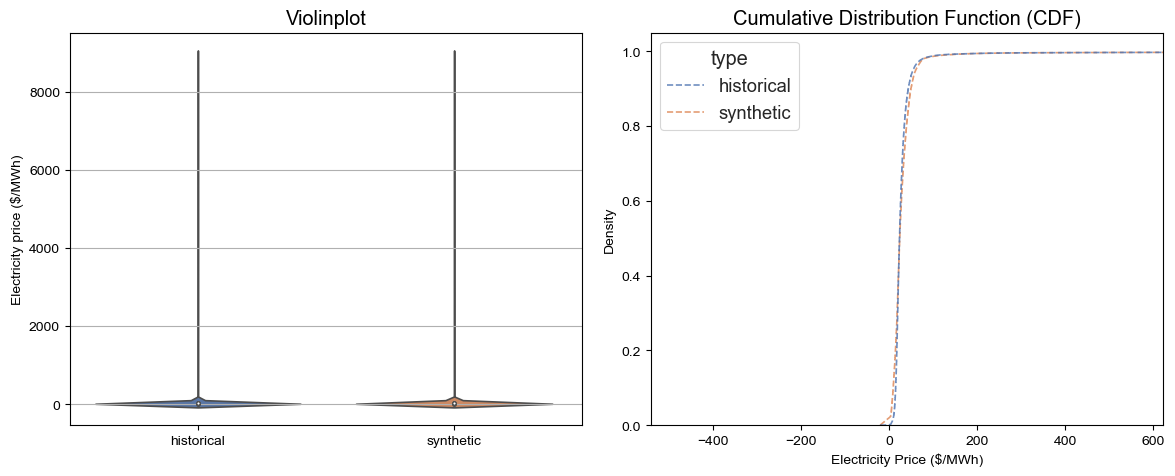

In [7]:
# Plot and save histograms and boxplots
fig, axes = plt.subplots(1,2,figsize =(12,5))

title = ' '.join(tag.split('_')).upper()+'\n Comparison of historical and synthetic data'
#fig.suptitle(title, y = 1.07)

mean  = stats['historical price']['mean']
price95 = 2*stats['historical price']['std']+mean
price05 = mean -2*stats['historical price']['std']
max_price = stats['historical price']['max']
quart1_price = stats['historical price']['25%']
min_price = stats['historical price']['min']
quart3_price = stats['historical price']['75%']
print(max_price, quart3_price, quart1_price, min_price)

sns.set_theme(style='whitegrid')
sns.set_context("paper", font_scale=1.5)

sns.violinplot(ax = axes[0],data=prices_df, x='type', y='price', alpha=0.8)

axes[0].set_title('Violinplot')
axes[0].set_ylabel('Electricity price ($/MWh)')
axes[0].set_xlabel('')
axes[0].grid(axis='y')

#sns.histplot(ax = axes[1,0], data=prices_df, x='price', hue='type', bins=5000, stat='density', common_norm=False)
#axes[1,0].set_title('Histogram')
#axes[1,0].set_xlabel('Electricity price ($/MWh)')
#axes[1,0].set_xlim(-25,200)

#sns.kdeplot(ax = axes[0,1], x='price', data=prices_df, hue='type', alpha= 0.5, multiple="stack",common_norm=False)
#axes[0,1].set_title('Kernel Density Function')
#axes[0,1].set_xlabel('Electricity Price ($/MWh)')
##axes[0,1].set_xlim(price05,price95)

sns.histplot(ax = axes[1], data=prices_df, x='price', hue='type', linestyle = "dashed", alpha=0.8,bins=len(prices_df), stat='density', element='step', fill=False,cumulative=True, common_norm=False)
axes[1].set_title('Cumulative Distribution Function (CDF)')
axes[1].set_xlabel('Electricity Price ($/MWh)')
axes[1].set_xlim(price05,price95)



#sns.histplot(ax = axes[2,0], data=prices_df, x='price', hue='type', bins=len(prices_df), stat='density', element='step', fill=True,cumulative=True, common_norm=False)
#axes[2,0].set_title('CDF, Upper end tail zoom')
#axes[2,0].set_xlabel('Electricity Price ($/MWh)')
#axes[2,0].set_xlim(min_price,max(0.75*min_price, 1.25*min_price))

#sns.histplot(ax = axes[2,1], data=prices_df, x='price', hue='type', bins=len(prices_df), stat='density', element='step', fill=True,cumulative=True, common_norm=False)
#axes[2,1].set_title('CDF, Lower end tail zoom')
#axes[2,1].set_xlabel('Electricity Price ($/MWh)')
#axes[2,1].set_xlim(0.99*max_price,max_price)

fig.tight_layout()
fig.savefig(tag+'_comparison_plots.png')

